# Eddington parameter estimation

In [1]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pint
import ipywidgets
%matplotlib inline

/Users/edy/lib/build/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/edy/lib/build/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
ur = pint.UnitRegistry()

## Problem setup

In [3]:
M_sol = 1.989*1e30
theta_GR = 1.75 * ur.arcsec

In [4]:
theta_GR

<Quantity(1.75, 'arcsecond')>

Bending angle:

\begin{equation}
    \theta
    =
    \frac{\alpha G M}{r c^{2}}
\end{equation}

- $\alpha = 2$: Newtonian
- $\alpha = 4$: GR

### Data model

\begin{equation}
\begin{aligned}
    Dx &= a x + b y + c + \alpha E_{x} \\
    Dy &= d x + e y + f + \alpha E_{y}
\end{aligned}
\end{equation}

where:
- $x$, $y$: coordinates of the stars
- $E_{x}$, $E_{y}$: coefficients of the gravitational displacement
- $c$, $f$: corrections to zero
- $a$, $e$: differences of scale value (caused be e.g. change in $T$)
- $b$, $d$: depend on the orientiation of the two plates
- $\alpha$: deflection at unit distance, i.e (50' from the Sun's centre)


**Parameter of Interest (POI):**
- $\alpha$

**Nuisance parameters (NP):**
- $a$, $b$, $c$, $d$, $e$, $f$

Errors on the displacement:
- 0.05

Parameter vector:

\begin{equation}
    \mathbf{\theta} = (\alpha, a,b,c,d,e,f)
\end{equation}

Likelihood: 
\begin{equation}
    \mathcal{L} (\theta, all data)
    =
    \prod_{i} \mathcal{L}_{i} (\theta, x_{i}, y_{i}, Ex_{i}, Ey_{i}, Dx_{i}, Dy_{i})
\end{equation}

Constructing required functions

In [5]:
def calc_Dx(x,y,alpha,a,b,c,Ex):
    Dx = a*x + b*y + c + alpha*Ex
    return Dx

In [6]:
def calc_Dy(x,y,alpha,d,e,f,Ey):
    Dy = d*x + e*y + f + alpha*Ey
    return Dy

In [101]:
def log_likelihood_one_star(par,x,y,Ex,Ey,Dx_obs,Dy_obs,error=0.05):
    
    alpha = par[0]
    a = par[1]
    b = par[2]
    c = par[3]
    d = par[4]
    e = par[5]
    f = par[6]
    Dx_mean = calc_Dx(x,y,alpha,a,b,c,Ex)
    Dy_mean = calc_Dy(x,y,alpha,d,e,f,Ey)
    log_p_Dx = scipy.stats.norm.logpdf(x=Dx_obs, loc=Dx_mean, scale=error)
    log_p_Dy = scipy.stats.norm.logpdf(x=Dy_obs, loc=Dy_mean, scale=error)
    likelihood = log_p_Dx + log_p_Dy
    
    return likelihood

In [102]:
def log_likelihood_combined(par, error=0.05):
    
    ll_comb = 0.0
    for index, star in stars.iterrows():
        x = star['x']
        y = star['y']
        Ex = star['Ex']
        Ey = star['Ey']
        Dx = star['Dx_obs']
        Dy = star['Dy_obs']
        ll_star  = log_likelihood_one_star(par,x,y,Ex,Ey,Dx_obs,Dy_obs,error)
        ll_comb += l_star
        
    return ll_comb

In [103]:
def create_df_with_Dx_Dy_preds(df_original, par, error=0.05):
    
    df = df_original.copy()

    df['Dx_pred'] = 0.0
    df['Dy_pred'] = 0.0
    df['log_likelihood'] = 0.0
        
    for index, star in df.iterrows():
        
        x = star['x']
        y = star['y']
        Ex = star['Ex']
        Ey = star['Ey']
        Dx_obs = star['Dx_obs']
        Dy_obs = star['Dy_obs']

        alpha = par[0]
        a = par[1]
        b = par[2]
        c = par[3]
        d = par[4]
        e = par[5]
        f = par[6]

        Dx_pred_ = calc_Dx(x,y,alpha,a,b,c,Ex)
        Dy_pred_ = calc_Dy(x,y,alpha,d,e,f,Ey)

        df.at[index, 'Dx_pred'] = Dx_pred_
        df.at[index, 'Dy_pred'] = Dy_pred_
        
        log_likelihood = log_likelihood_one_star(par, x, y, Ex, Ey, Dx_obs, Dy_obs, error)
        print(log_likelihood)
        df.at[index, 'log_likelihood'] = log_likelihood
        
        #df.iloc[idx]['Dx_pred'] = Dx_pred
        #df.iloc[idx]['Dy_pred'] = Dy_pred
        
    return df

### Loading in data

In [104]:
stars = pd.read_csv('eddington.dat', delim_whitespace=True, header=1, skiprows=0)

Correcting $Dx$ and $Dy$

In [105]:
stars['Dx_obs'] = stars['Dx_obs_uncorrected']+1.5
stars['Dy_obs'] = stars['Dy_obs_uncorrected']+1.324

In [106]:
stars

,x,y,Ex,Ey,Dx_obs_uncorrected,Dy_obs_uncorrected,Dx_obs,Dy_obs
0,-1.261,-0.160,-0.587,0.036,-1.416,-1.324,0.084,0.000
1,-0.160,-1.107,-0.557,-0.789,-1.221,-1.312,0.279,0.012
2,0.334,0.472,-0.186,1.336,-1.054,-0.944,0.446,0.380
3,0.348,0.360,-0.222,1.574,-1.079,-0.862,0.421,0.462
4,0.587,1.099,0.080,0.726,-1.012,-0.932,0.488,0.392
5,0.860,1.321,0.158,0.589,-0.999,-0.948,0.501,0.376
6,1.079,-0.328,1.540,-0.156,-0.733,-1.019,0.767,0.305


### Exploration

#### Position of the stars $(x,y)$

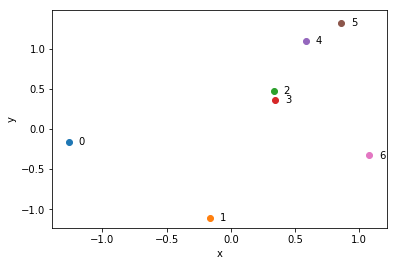

In [107]:
f,a = plt.subplots()

for idx,star in stars.iterrows():
    label = "star {}".format(idx)
    c = "C{}".format(idx)
    x = star['x']
    y = star['y']
    a.scatter(x, y, label=label, c=c)
    txt = "{}".format(idx)
    a.text(x+0.1, y, txt, verticalalignment='center', horizontalalignment='center')
    
a.set_xlabel('x')
a.set_ylabel('y');

#### Deflections $(Dx,Dy)$

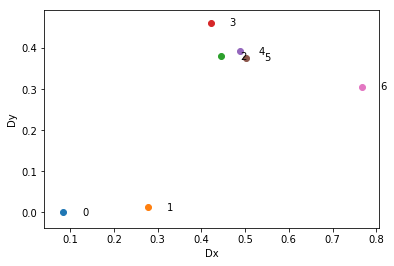

In [108]:
f,a = plt.subplots()

for idx,star in stars.iterrows():
    label = "star {}".format(idx)
    c = "C{}".format(idx)
    Dx_obs = star['Dx_obs']
    Dy_obs = star['Dy_obs']
    a.scatter(Dx_obs, Dy_obs, label=label, c=c)
    txt = "{}".format(idx)
    a.text(Dx_obs+0.05, Dy_obs, txt, verticalalignment='center', horizontalalignment='center')
    
a.set_xlabel('Dx')
a.set_ylabel('Dy');

### Testing a specific prediction

In [109]:
par = (1.75/19.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [110]:
stars_with_pred = create_df_with_Dx_Dy_preds(stars, par)

0.4588164356522091
-18.729489667041417
-52.33678375182864
-55.526617651430755
-63.59994836768418
-64.2747730399115
-95.77571287640774


In [111]:
stars_with_pred

,x,y,Ex,Ey,Dx_obs_uncorrected,Dy_obs_uncorrected,Dx_obs,Dy_obs,Dx_pred,Dy_pred,log_likelihood
0,-1.261,-0.160,-0.587,0.036,-1.416,-1.324,0.084,0.000,-0.051881,0.003182,0.458816
1,-0.160,-1.107,-0.557,-0.789,-1.221,-1.312,0.279,0.012,-0.049230,-0.069735,-18.729490
2,0.334,0.472,-0.186,1.336,-1.054,-0.944,0.446,0.380,-0.016439,0.118081,-52.336784
3,0.348,0.360,-0.222,1.574,-1.079,-0.862,0.421,0.462,-0.019621,0.139116,-55.526618
4,0.587,1.099,0.080,0.726,-1.012,-0.932,0.488,0.392,0.007071,0.064167,-63.599948
5,0.860,1.321,0.158,0.589,-0.999,-0.948,0.501,0.376,0.013965,0.052058,-64.274773
6,1.079,-0.328,1.540,-0.156,-0.733,-1.019,0.767,0.305,0.136111,-0.013788,-95.775713


Initializiation

In [ ]:
par0 = (1.75/19.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [116]:
l0 = log_likelihood_combined(par)

NameError: name 'l_star' is not defined

In [ ]:
def proposal_function(par):
    
    scipy.stats.multinomial()
    

In [ ]:
nsamples = 1e4

likelihoods = []
pars = []

for iteration in range(nsamples):
    
    p = scipy.stats.uniform.rvs()
    
    
    l_new = likelihood(par)
    r = l_new/likelihood[iterarion]
    
    if p < r:
        pass
    else:
        pass
    
    likelihoods.append(l_new)
    pars.append(par_new)
    